## Quora Question-pair classification

This project idea is taken from the kaggle competition about modeling whether a pair of questions on Quora is semantically same or not. For this problem, there are over 400,000 training examples. Each row consists of two numeric Id's for each question, two question texts, and a binary label that indicates to us whether the two questions are duplicate in meaning or not.
<br><br>
<div>
<p> Steps to build the model:
   <ul>
    <li>Exploratory Data Analysis </li>
    <li>Data wrangling: Handle missing data, duplic rows, and outliers</li>
    <li>Basic feature engineering  </li>
    <li>TF-IDF encodings of the question pair texts</li>
    <li>Model selection and evaluation</li>
    <li>Model refinement and improving the performance</li>
    </ul>
</p>
</div>

In [1]:
# import the important libraries/packages
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
%matplotlib inline
import nltk
import seaborn as sns
import gensim

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# load the training dataset
train_data = pd.read_csv('D:\Downloads\Springboard Python\quora-question-pair\\train.csv')

In [3]:
# load the test dataset 
test_data = pd.read_csv('D:\Downloads\Springboard Python\quora-question-pair\\test.csv')

C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. EDA

### Training data analysis

**1.1 A few rows of the traning dataset**

In [4]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


**1.2 Columns of the training  data set**

In [5]:
train_data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

**1.3 Size of the Datasets**

In [6]:
print("Size of the test data: ", test_data.shape)
print("Size of the train data: ", train_data.shape)

Size of the test data:  (3563475, 3)
Size of the train data:  (404290, 6)


**1.4 Data type of each columns and the Missing Data**

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<div class ='span5 alert alert-info'> 
 <strong>  NOTE: There are 2 missing data in 'question2' column.</strong>
</div>

Since the missing data is very small percentange of the total dataset, we will remove these rows for a better performance. 

In [8]:
# Drop The missing value and duplicate rows
train_df = train_data.dropna()
train_df = train_df.drop_duplicates()

# Data type and info after dropping the na values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404288 entries, 0 to 404289
Data columns (total 6 columns):
id              404288 non-null int64
qid1            404288 non-null int64
qid2            404288 non-null int64
question1       404288 non-null object
question2       404288 non-null object
is_duplicate    404288 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


**1.5 Number of duplicate and non-duplicate questoion-pairs:**

In [9]:
train_df.groupby("is_duplicate")['id'].count()

is_duplicate
0    255025
1    149263
Name: id, dtype: int64

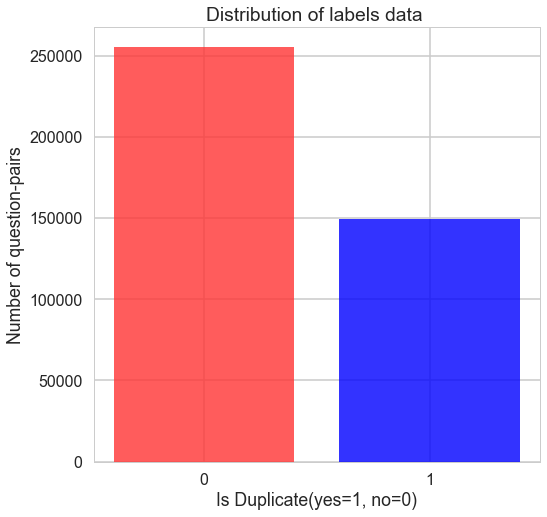

In [10]:
plt.figure(figsize=(8, 8))
plt.bar([0,1],train_df.groupby("is_duplicate")['id'].count(),color=[(1,0.2,0.2,0.8), ((0,0,1,0.8))])
plt.xticks([0,1])
plt.xlabel('Is Duplicate(yes=1, no=0)')
plt.ylabel('Number of question-pairs')
plt.title("Distribution of labels data ")
plt.show()

## 'question1' column character-length insights

**1.6 Number of characters in the  questions in question1 column**

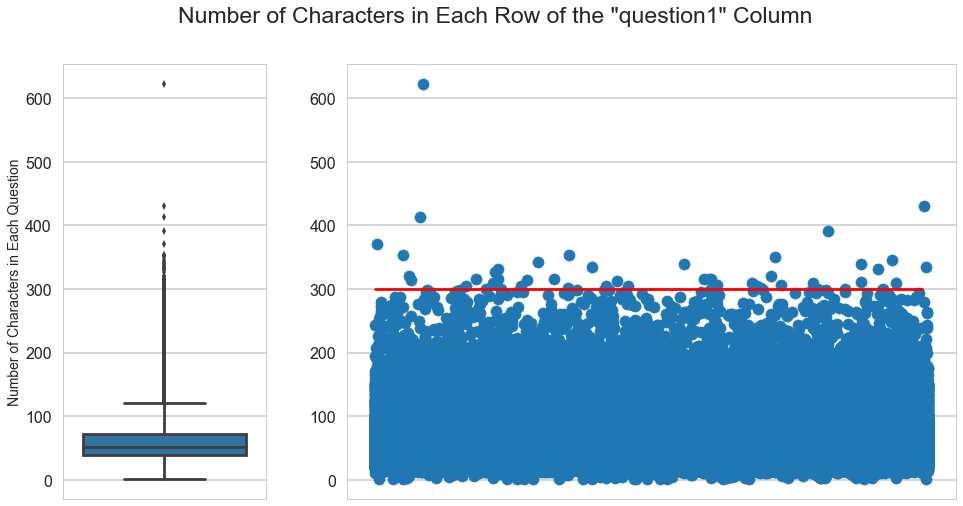

In [11]:
import matplotlib.gridspec as gridspec
sns.set_style('whitegrid')

# set the figure size and add a title 
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Number of Characters in Each Row of the "question1" Column')
fig.set_label(s='Question1')

# create the figure grids 
gs = gridspec.GridSpec(ncols=2,nrows=1, width_ratios=[1, 3])

# plot the boxplot of the question1 character length
ax1 = plt.subplot(gs[0])
sns.boxplot(sorted(train_df.question1.str.len(),reverse=True), orient='v', )
plt.ylabel("Number of Characters in Each Question",size=14)

# plot the scatter plot in the second grid
ax2 = plt.subplot(gs[1])
plt.scatter(np.arange(len(train_df.question1)), train_df.question1.str.len())
plt.plot([-2,400000],[300,300], color='r')
plt.yticks(range(0,640,100))
plt.xticks([])
plt.show()

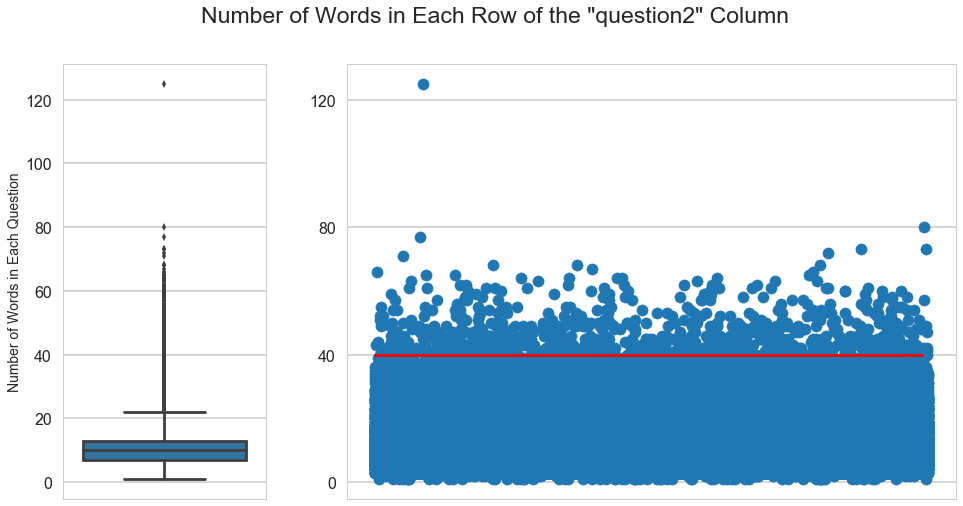

In [12]:
# set the figure size and add a title 
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Number of Words in Each Row of the "question2" Column')

# create the figure grids 
gs = gridspec.GridSpec(ncols=2,nrows=1, width_ratios=[1, 3])

# plot the boxplot of the question1 character length
ax1 = plt.subplot(gs[0])
sns.boxplot(sorted(train_df.question1.str.split().str.len(),reverse=True), orient='v')
plt.ylabel("Number of Words in Each Question",size=14)

# plot the scatter plot in the second grid
ax2 = plt.subplot(gs[1])
plt.scatter(np.arange(len(train_df.question1)), train_df.question1.str.split().str.len())
plt.plot([-1,400000],[40,40], color='r')
plt.yticks(range(0,130,40))
plt.xticks([])
plt.show()

### questionn2 column character-length insight

**1.7 Number of the characters in the questions in question2 columns**

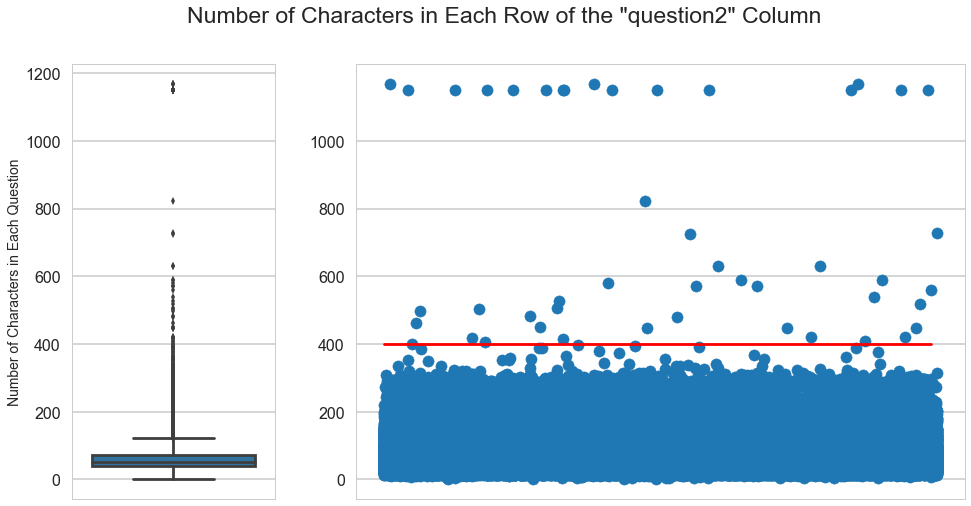

In [13]:
# set the figure size and add a title 
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Number of Characters in Each Row of the "question2" Column')
fig.set_label(s='Question1')

# create the figure grids 
gs = gridspec.GridSpec(ncols=2,nrows=1, width_ratios=[1, 3])

# plot the boxplot of the question1 character length
ax1 = plt.subplot(gs[0])
sns.boxplot(sorted(train_df.question2.str.len(),reverse=True), orient='v')
plt.ylabel("Number of Characters in Each Question",size=14)

# plot the scatter plot in the second grid
ax2 = plt.subplot(gs[1])
plt.scatter(np.arange(len(train_df.question2)), train_df.question2.str.len())
plt.plot([-1,400000],[400,400], color='r')
plt.yticks(range(0,1200,200))
plt.xticks([])
plt.show()

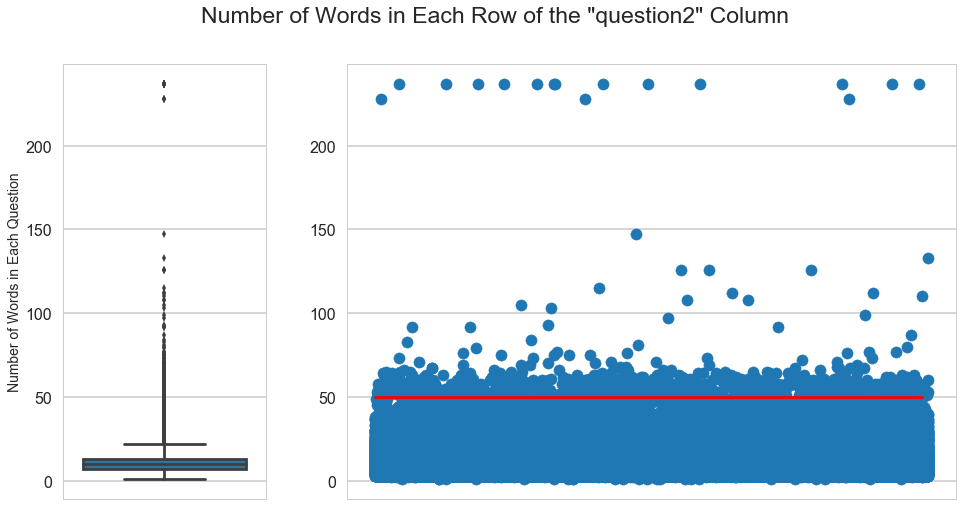

In [14]:
# set the figure size and add a title 
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Number of Words in Each Row of the "question2" Column')

# create the figure grids 
gs = gridspec.GridSpec(ncols=2,nrows=1, width_ratios=[1, 3])

# plot the boxplot of the question1 character length
ax1 = plt.subplot(gs[0])
sns.boxplot(sorted(train_df.question2.str.split().str.len(),reverse=True), orient='v')
plt.ylabel("Number of Words in Each Question",size=14)

# plot the scatter plot in the second grid
ax2 = plt.subplot(gs[1])
plt.scatter(np.arange(len(train_df.question2)), train_df.question2.str.split().str.len())
plt.plot([-1,400000],[50,50], color='r')
plt.yticks(range(0,250,50))
plt.xticks([])
plt.show()

### 1.8 Observations and comments:
<hr>
<div>
<ul>
<li> From the box plot it is clear that, the distributions of the question character-lengths are right skewed </li>
<li> More than 99% questions are below 280 character-lengths.</li>
<li> Median character-length for both question1 column is approximately 60, where for question2 column it is about 120</li>
</ul>
<hr>
</div>

### 1.9 Most Common words in the question-pairs 

In [15]:
# remove all the punctuation and noises from quetion1 text
text1 = " ".join(train_data['question1']).lower()
text1 = gensim.parsing.strip_punctuation2(text1)
text1 = gensim.parsing.strip_short(text1, minsize=2)

# remove all the punctuation and noises from question2 text 
text2 = " ".join(train_data["question2"].fillna("")).lower()
text2 = gensim.parsing.strip_punctuation2(text2)
text2 = gensim.parsing.strip_short(text2, minsize=2)

In [16]:
# importing wordcloud module
from wordcloud import WordCloud

# generate a WordCloud for question1
stopwords = nltk.corpus.stopwords.words('english')
question1_wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                contour_width=3,
                contour_color='steelblue').generate(text1)

question2_wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                contour_width=3,
                contour_color='steelblue').generate(text2)

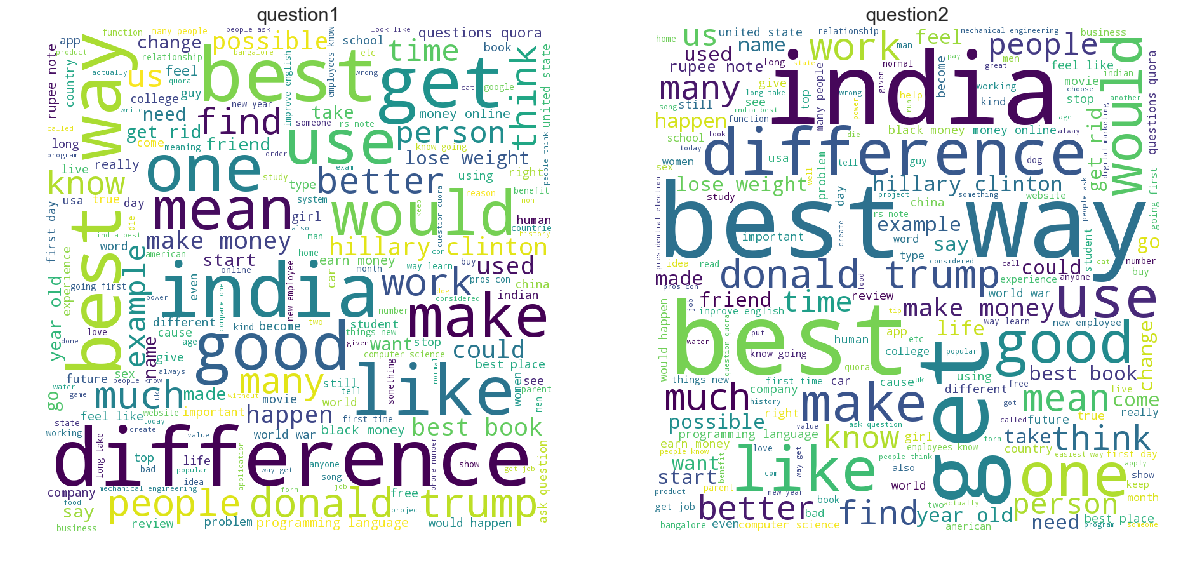

In [17]:
# create the figure grids 
plt.figure(figsize = (20, 10))
gs = gridspec.GridSpec(ncols=2,nrows=1)

# plot the WordCloud images                       
ax1 = plt.subplot(gs[0])
plt.imshow(question1_wc)
plt.axis("off") 
plt.title('question1')

ax2 = plt.subplot(gs[1])
plt.imshow(question2_wc)
plt.axis("off") 
plt.title('question2')
plt.show() 

## 2. Text Preprocessing and Feature Engineering

### 2.1 Text Processors 

All text column need to be combined row-wise before vectorizing the data. For a better result, noisy data such as word counts outliers, character count outliers,  foreign characters, punctuations need to be removed before tokenize and vectorize the text data. combined_Text will combine all the text data row-wise and preProcessText functino will perform the remaining text processing.

In [18]:
def combined_Text(df, to_combine = ['question1', 'question2']):
    """ converts all text in each row of data_frame to single vector """
    
    # Data frame with the text columns that are in the df
    text_data = df[to_combine]
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)


In [19]:
def preProcessText(text):
    """ This function takes a text or list of text as its input and returns a processed text.
        1. Change the string to lower case
        2. Remove non utf-8 characters
        3. Remove common stopwords 
        4. Remove all the punctuation2
        5. Remove multiple whitespaces
        6. Remove all the single characters or numbers
        6. Stem the text  """
    
    # Convert text to lower
    text = text.lower()
    
    # Removing all the non-alphanumeric characters    
    text = gensim.parsing.preprocessing.strip_non_alphanum(text)
    
    # Removing all the stopwords
    text = gensim.parsing.preprocessing.remove_stopwords(text)
   
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Strip single characters and numbers
    text = gensim.parsing.preprocessing.strip_short(text, minsize=2)
        
    # Stemming: gensim.parsing.PorterStem() or
    return gensim.parsing.preprocessing.stem_text(text)

### 2.2 Feature engineering 
The given features are the question text pairs. After the text processing, many words, alphanumeric characters, and other characters will be removed, and the remaining text will be converted to the lowercase. It may result in significant information loss. That is why, it is necesary to add extra features such as number of words in a question, numbers of character in the questions.

In [20]:
def preProcess_datframe(data):
    """ adds new features to the dataset e.g. character length and the number of words in each question."""
    data['char_len1'] = data.question1.str.len()
    data['char_len2'] = data.question2.str.len()
    data['wlen1'] = data.question1.str.split().str.len()
    data['wlen2'] = data.question2.apply( lambda x: len(x.split(' ')))
    data['question1'] = data.question1.apply( lambda x: preProcessText(x))
    data['question2'] = data.question2.apply( lambda x: preProcessText(x))
    return data

#### 2.3 preprocess and add featurs to the training data
- Remove the outliers from the dataset
- Add word count and character count features
- Filter out the rows with Incorrect labels
- Seperate the features and the label to build the a model 

In [21]:
# remove outliers from the train data
train_df = train_data[(train_data.question1.str.len()<300)]

# remoe outlier from the test data
train_df = train_df[(train_df.question2.str.len()<400)]

# add word count and character count features to the train dataset
X = preProcess_datframe(train_df[['question1', 'question2']].dropna())

# remove incorretly labeled data
inconsistent_labels = (X.question1 == X.question2) > train_df['is_duplicate']
X = X[~inconsistent_labels]
y = train_df[~inconsistent_labels]['is_duplicate']

**2.1 Seperate a hold-out dataset to test the model**

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

## 3. Training Models

**3.1 Create a pipeline**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

get_text_data = FunctionTransformer(combined_Text, validate=False)
get_num_data = FunctionTransformer(lambda x:x[X.columns.tolist()[2:]], validate=False)

pl = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer())
                ]))
             ])
     
    ),('clf', MultinomialNB())])


In [31]:
# fit the pipelined model to the train data
pl.fit(X_train, y_train)
y_pred_proba = pl.predict_proba(X_test)

In [32]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)

0.53785287847212138

## 4. Evaluation on the test data set

In [34]:
# find the index of the valid question pairs
valid_ids =[type(x)==int for x in test_data.test_id]

In [35]:
# remove all the invalid question pairs from the test dataset
test_df = test_data[valid_ids].drop_duplicates()

In [36]:
# add the extra features to the dataset
test_X = preProcess_datframe(test_df[['question1', 'question2']].fillna(" "))

In [37]:
y_pred_proba_test = pl.predict_proba(test_X)

In [38]:
# save the data in the csv file for kaggle submission 
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_pred_proba_test[:,1]

In [39]:
submission_file.to_csv('submission.csv', index=False)

***Kaggle Competition Score***
- Public Score: 0.43864
- Private Score: 0.44003

## 5.  Model Refining

**5.1 Find the best alpha for the classifier**

In [40]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [41]:
# potential best parameters for gridsearch
parameters = {'clf__alpha': [0.01, 0.05, 0.1, 0.15, 0.2]}

# initialize the gridsearch with the log_loss metrics
searcher = GridSearchCV(pl, parameters, cv=3, scoring='neg_log_loss')

In [42]:
# find the best parameter with the training data
searcher.fit(X_train, y_train)

In [43]:
# best value for alphha
searcher.best_params_

In [44]:
# prediction proability on the hold-out dataset
y_searcher = searcher.predict_proba(X_test)
print("Log loss score with alpha=0.15: {}".format(log_loss(y_test, y_searcher)))

## 6.  Further improvement using n-gram and best parameter for Tf-idf vectorizer##

In [45]:
# find the best min_df value for the the Tfidfvectorizer
logloss_count = None
logloss_min = 10
min_df_count = None
for min_df in [1, 10, 20, 40]:
    pl_n_gram = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB())])
    pl_n_gram.fit(X_train, y_train)
    y_n_gram = pl_n_gram.predict_proba(X_test) 
    logloss_count = log_loss(y_test, y_n_gram)
    if logloss_count < logloss_min:
        logloss_min = logloss_count
        min_df_count = min_df
        
print('Best min_df : {}'.format(min_df_count))

In [46]:
# best Logloss score with all improved parameters 
print("Improved log_loss score : {}".format(logloss_min))

In [47]:
    pl_n_gram = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df=10, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(0.01))])

In [48]:
# fit the pipelined model to the train data
pl_n_gram.fit(X_train, y_train)

In [49]:
# Prediction probability of the Testing dataset with the improved parameters 
test_y_n_gram = pl_n_gram.predict_proba(test_X)

In [50]:
submission_file['is_duplicate'] = y_pred_proba_test[:,1]
submission_file.to_csv('submission_n_gram.csv', index=False)

***Updated Kaggle Competition Score***
- Public Score: 0.430
- Private Score: 0.431


### 5.4     Evaluation on test data set using the updated min_df, alpha, and n_gram

In [51]:
# Improved pipeline with min_df, alpha, and n_gram
pl_n_gram = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df = 10, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(alpha=0.15))])

In [52]:
# fit the pipelined model to the train data
pl_n_gram.fit(X, y)

In [53]:
y_n_gram_total = pl_n_gram.predict_proba(test_X)

In [54]:
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_n_gram_total[:,1]
submission_file.to_csv('submission_n_gram_total.csv', index=False)

***Further Updated Kaggle Competition Score***
- Public Score: 0.404
- Private Score: 0.405

### 6. Update model with Doc2Vec default parameters 

In [55]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.spatial.distance import cosine, euclidean

In [ ]:
# load previously trained doc2vec model with default parameter. 
d2v = Doc2Vec.load('doc2vec_quora')

In [57]:
# vectorize training data
X_question1_vectors = X.question1.apply(d2v.infer_vector)
X_question2_vectors = X.question2.apply(d2v.infer_vector)
test_question1_vectors = test_X.question1.apply(d2v.infer_vector)
test_question2_vectors = test_X.question2.apply(d2v.infer_vector)

In [58]:
# cosine and euclidean features of the training dataset 
X['cos'] = [cosine(X_question1_vectors[i], X_question2_vectors[i]) for i in X_question1_vectors.index]
X['euclid'] = [euclidean(X_question1_vectors[i], X_question2_vectors[i]) for i in X_question1_vectors.index]

In [59]:
# consine and euclidead distance features of the testdata
test_X['cos'] = [cosine(test_question1_vectors[i], test_question2_vectors[i]) for i in test_question1_vectors.index]
test_X['euclid'] = [euclidean(test_question1_vectors[i], test_question2_vectors[i]) for i in test_question1_vectors.index]

In [60]:
# Improved pipeline with for d2v model
pl_d2v = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df = 10, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(alpha=0.15))])

In [61]:
# train the pipeline on training dataset 
pl_d2v.fit(X, y)

# predict the probablity on the test dataset
y_d2v = pl_d2v.predict_proba(test_X)

In [62]:
# save the prediction probability data in the submission file 
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_d2v[:,1]
submission_file.to_csv('submission_d2v.csv', index=False)

***Updated Kaggle Competition Score with Doc2vec***
- Public Score: 0.403
- Private Score: 0.404

### 7. Update the model with Doc2vec Hyperparameter Tuning

In [63]:
# Train a Doc2Vec Model over the training data with tuned parameters
tempu = train_data.question1 + " "+ train_data.question2
tempu = tempu.str.lower().apply(gensim.parsing.preprocessing.strip_punctuation2)
tempu = tempu.apply(gensim.parsing.preprocessing.strip_non_alphanum)
tempu = tempu.apply(gensim.parsing.preprocessing.remove_stopwords)
tempu = tempu.apply(gensim.parsing.preprocessing.strip_multiple_whitespaces).str.split(" ")
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tempu.tolist())]
d2v_model = Doc2Vec(documents, vector_size=100, window=7, min_count=2, workers=8, epochs=10)
d2v_model.save('doc2vec_quora_tuned')

In [64]:
# vectorize training data
X_question1_vectors = train_df.question1.apply(d2v_model.infer_vector)
X_question2_vectors = train_df.question2.apply(d2v_model.infer_vector)

In [65]:
# vectorize test data
test_question1_vectors = test_X.question1.apply(d2v_model.infer_vector)
test_question2_vectors = test_X.question2.apply(d2v_model.infer_vector)

In [66]:
# add the cosine and euclidean distance features to the train datasets 
X['cos'] = [cosine(X_question1_vectors[i], X_question2_vectors[i]) for i in X_question1_vectors.index]
X['euclid'] = [euclidean(X_question1_vectors[i], X_question2_vectors[i]) for i in X_question1_vectors.index]

# add the cosine and euclidean distance features to the test datasets 
test_X['cos'] = [cosine(test_question1_vectors[i], test_question2_vectors[i]) for i in test_question1_vectors.index]
test_X['euclid'] = [euclidean(test_question1_vectors[i], test_question2_vectors[i]) for i in test_question1_vectors.index]

In [67]:
# Improved pipeline with for d2v model
pl_d2v_model = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df = 10, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(alpha=0.15))])

In [68]:
# train the pipeline over the training data
pl_d2v_model.fit(X, y)

# predict the probability on the test dataset
y_d2v_model = pl_d2v.predict_proba(test_X)

In [69]:
# prepare the submission file for kaggle
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_d2v_model[:,1]
submission_file.to_csv('submission_d2v_test.csv', index=False)

***Updated Kaggle Competition Score with Doc2vec***
- Public Score: 0.398</li>
- Private Score: 0.399</li>


### 8. Update the model with a pretrained Doc2vec on wikipidea data

In [70]:
# load pretrained model on wikipedia corpus
d2v_en_wiki = Doc2Vec.load('doc2vec.bin')

C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\models\doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
C:\Users\Plabon\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [71]:
# vectorize training data
X_question1_vectors = train_df[~inconsistent_labels].question1.apply(lambda x: d2v_en_wiki.infer_vector(x, epochs=10))
X_question2_vectors = train_df[~inconsistent_labels].question2.apply(lambda x: d2v_en_wiki.infer_vector(x, epochs=10))

In [73]:
# vectorize test data
test_df = test_df.fillna(" ")
test_question1_vectors = test_df.question1.apply(lambda x: d2v_en_wiki.infer_vector(x, epochs=10))
test_question2_vectors = test_df.question2.apply(lambda x: d2v_en_wiki.infer_vector(x, epochs=10))

In [74]:
# add the cosine and euclidean distance features to the datasets 
X['cos'] = [cosine(X_question1_vectors[i], X_question2_vectors[i]) for i in X_question1_vectors.index]
X['euclid'] = [euclidean(X_question1_vectors[i], X_question2_vectors[i]) for i in X_question1_vectors.index]

# add the cosine and euclidean distance features to the test datasets 
test_X['cos'] = [cosine(test_question1_vectors[i], test_question2_vectors[i]) for i in test_question1_vectors.index]
test_X['euclid'] = [euclidean(test_question1_vectors[i], test_question2_vectors[i]) for i in test_question1_vectors.index]

In [75]:
# Improved pipeline with for d2v model
pl_d2v_model = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df = 10, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(alpha=0.15))])

In [76]:
# train the pipeline over the training data
pl_d2v_model.fit(X, y)

# predict the probability on the test dataset
y_d2v_model = pl_d2v_model.predict_proba(test_X)

In [77]:
# prepare the submission file for kaggle
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_d2v_model[:,1]
submission_file.to_csv('submission_d2v_wiki.csv', index=False)

***Updated Kaggle Competition Score with Doc2vec***
- Public Score: 0.404
- Private Score: 0.405


## 9. Experiments with different classifiers ##

Naive bayes classifier is a simple and efficient classifier, but may not produce the best result. Currently quora uses random forest classifier for the duplicate detection. Here we will experiment with a few other classifier using the pretrained doc2vec features only.

### 9.1 MultinomialNB 

In [95]:
# create 2D positive matrices for traning and testing
new_X = np.concatenate((np.array(X_question1_vectors.tolist()), np.array(X_question2_vectors.tolist())), axis=1)**2
new_test_X = np.concatenate((np.array(test_question1_vectors.tolist()), np.array(test_question2_vectors.tolist())), axis=1)**2

In [101]:
# Multinomial Naive Bayes model
nb_model = MultinomialNB(alpha=0.15)
nb_model.fit(new_X, y )

MultinomialNB(alpha=0.15, class_prior=None, fit_prior=True)

In [102]:
# calculate prediction probability
y_proba_nb  = nb_model.predict_proba(new_test_X)

In [103]:
# prepare the submission file for kaggle
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_proba_nb[:,1]
submission_file.to_csv('submission_nb.csv', index=False)

***Kaggle Evaluation Score***
- Public Score: 0.560
- Private Score: 0.561


### 9.2 Logitic Regression Classifier ###

In [110]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
# initialize a logistic regression classifier with cross validation for parameter-tuning
reg = LogisticRegressionCV(cv=5, Cs=np.logspace(-1, 1, 5), random_state=42)

In [115]:
# create 2d matrices for the training and testing 
new_X = np.concatenate((np.array(X_question1_vectors.tolist()), np.array(X_question2_vectors.tolist())), axis=1)
new_test_X = np.concatenate((np.array(test_question1_vectors.tolist()), np.array(test_question2_vectors.tolist())), axis=1)

In [116]:
# train the classification
reg.fit(new_X, y)

LogisticRegressionCV(Cs=array([  0.1    ,   0.31623,   1.     ,   3.16228,  10.     ]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=42, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [117]:
# calculate the prediction probability
y_proba_reg = reg.predict_proba(new_test_X)

In [118]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_proba_svm[:,1]
submission_file.to_csv('submission_logit.csv', index=False)

***Kaggle Evaluation Score***
- Public Score: 0.541
- Private Score: 0.542

### 9.3 Support Vectore Machine

In [135]:
from sklearn.svm import SVC

In [177]:
# initializa a svm classifier
svm_clf = SVC(C=10, gamma=0.001, probability=True)

In [179]:
# select a random subset of the data to train the classifier
np.random.seed(45)
row_no = np.random.choice(len(new_X), size=15000, replace=False)
seleceted_X = new_X[row_no, :]
seleceted_y = y.iloc[row_no]

In [ ]:
# train the classifier
svm_clf.fit(seleceted_X, seleceted_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [185]:
# calculate the prediction probability
y_proba_svm = svm_clf.predict_proba(new_test_X)   

In [186]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_proba_svm[:,1]
submission_file.to_csv('submission_svm.csv', index=False)

***Kaggle Evaluation Score***
- Public Score: 0.550
- Private Score: 0.551

## 9.4 KNN

In [191]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [194]:
# grid search for the best parameter for the knn classifier
knn_searcher = GridSearchCV(knn,{'n_neighbors': [5, 8, 10, 15]}, cv=3, scoring='neg_log_loss')

In [ ]:
# train the classifier with the best parameter
knn_searcher.fit(new_X, y)

In [ ]:
# calculate the prediction probability
y_proba_knn = knn_searcher.predict_proba(new_test_X)   

In [ ]:
# prepare the submission file for kaggle
submission_file['is_duplicate'] = y_proba_knn [:,1]
submission_file.to_csv('submission_knn.csv', index=False)

### 9. Recommendations

This model is built on the basic Naive Base classifier with very minimal parameter tuning due to the time constraints. Further, parameter tuning with cross validation of different folding of the training data set would definitely improve the model. Besides, this model only uses a few features such as the text of the quetions, word counts, character counts, and vector space distances. It also ignores the case of the characters, foreign characters, and special characters, which may casuse a potential information loss.
For future experiment some recommended steps are following: 

- Correct misspelled words, replace abbreviation with the complete words
- Further correction of the labeling to minimize the errors
- Add special characters count, word share ratio, capitalization count as features
- Besides cosine and euclidean distances, other distance features can be added
- Fuzzy ratio features can be added 
- Deep learning implementation such as word2vec, artificial neural networks etc